# Prepping data

In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
kwargs = dict(consolidated=True, use_cftime=True, engine="zarr")
    
print("Load Data")
ocean_path = "gs://cmip6/GFDL_CM2_6/control/surface"
ds_ocean = xr.open_dataset(fs.get_mapper(ocean_path), chunks={"time": 3}, **kwargs)

ocean_boundary_path = "gs://cmip6/GFDL_CM2_6/control/ocean_boundary"
ds_ocean_boundary = xr.open_dataset(fs.get_mapper(ocean_boundary_path), chunks={"time": 3}, **kwargs)

grid_path = "gs://cmip6/GFDL_CM2_6/grid"
ds_ocean_grid = xr.open_dataset(fs.get_mapper(grid_path), chunks={}, **kwargs)

# combine all dataset on the ocean grid together
ds_ocean = xr.merge([ds_ocean_grid, ds_ocean, ds_ocean_boundary], compat='override')
ds_ocean

Load Data


<xarray.Dataset> Size: 12TB
Dimensions:                    (yt_ocean: 2700, xt_ocean: 3600, yu_ocean: 2700,
                                xu_ocean: 3600, st_edges_ocean: 51,
                                st_ocean: 50, sw_edges_ocean: 51, sw_ocean: 50,
                                nv: 2, st_ocean_sub01: 1, time: 7400)
Coordinates: (12/30)
    area_t                     (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    area_u                     (yu_ocean, xu_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt                        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxu                        (yu_ocean, xu_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt                        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyu                        (yu_ocean, xu_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ...                         ...
  * xu_ocean                   (xu_ocean) float64 29kB -279.9 -279.8 ... 80.0
  * yt_ocean                   (yt_ocean) float64 22kB -81.11 -81.07 ... 89.98
  * yu_ocean                   (yu_ocean) float64 22kB -81.09 -81.05 ... 90.0
  * nv                         (nv) float64 16B 1.0 2.0
  * st_ocean_sub01             (st_ocean_sub01) float64 8B 5.034
  * time                       (time) object 59kB 0181-01-01 12:00:00 ... 020...
Data variables: (12/41)
    biomass_p                  (time, yt_ocean, xt_ocean) float32 288GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    chl                        (time, yt_ocean, xt_ocean) float32 288GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    dic                        (time, yt_ocean, xt_ocean) float32 288GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    htotal                     (time, yt_ocean, xt_ocean) float32 288GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    irr_mix                    (time, st_ocean_sub01, yt_ocean, xt_ocean) float32 288GB dask.array<chunksize=(3, 1, 2700, 3600), meta=np.ndarray>
    kw                         (time, yt_ocean, xt_ocean) float32 288GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    ...                         ...
    sfc_hflux_pme              (time, yt_ocean, xt_ocean) float32 288GB dask.array<chunksize=(106, 2700, 3600), meta=np.ndarray>
    swflx                      (time, yt_ocean, xt_ocean) float32 288GB dask.array<chunksize=(106, 2700, 3600), meta=np.ndarray>
    tau_x                      (time, yu_ocean, xu_ocean) float32 288GB dask.array<chunksize=(106, 2700, 3600), meta=np.ndarray>
    tau_y                      (time, yu_ocean, xu_ocean) float32 288GB dask.array<chunksize=(106, 2700, 3600), meta=np.ndarray>
    wind_power_u               (time, yu_ocean, xu_ocean) float32 288GB dask.array<chunksize=(106, 2700, 3600), meta=np.ndarray>
    wind_power_v               (time, yu_ocean, xu_ocean) float32 288GB dask.array<chunksize=(106, 2700, 3600), meta=np.ndarray>
Attributes:
    NCO:      4.0.3

In [4]:
print("Interpolating ocean velocities")
# interpolate ocean velocities onto the tracer points using xgcm
from xgcm import Grid

# add xgcm comodo attrs
ds_ocean["xu_ocean"].attrs["axis"] = "X"
ds_ocean["xt_ocean"].attrs["axis"] = "X"
ds_ocean["xu_ocean"].attrs["c_grid_axis_shift"] = 0.5
ds_ocean["xt_ocean"].attrs["c_grid_axis_shift"] = 0.0
ds_ocean["yu_ocean"].attrs["axis"] = "Y"
ds_ocean["yt_ocean"].attrs["axis"] = "Y"
ds_ocean["yu_ocean"].attrs["c_grid_axis_shift"] = 0.5
ds_ocean["yt_ocean"].attrs["c_grid_axis_shift"] = 0.0
grid = Grid(ds_ocean)


# fill missing values with 0, then interpolate.
tracer_ref = ds_ocean["surface_temp"]
sst_wet_mask = ~np.isnan(tracer_ref)

ds_ocean["u_ocean"] = grid.interp_like(
    ds_ocean["usurf"].fillna(0), tracer_ref
).where(sst_wet_mask)
ds_ocean["v_ocean"] = grid.interp_like(
    ds_ocean["vsurf"].fillna(0), tracer_ref
).where(sst_wet_mask)

Interpolating ocean velocities


In [5]:
# xarray says not to do this
# ds_atmos = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr', chunks={'time':1}, **kwargs) # noqa: E501
atmos_path = "gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr"
ds_atmos = xr.open_dataset(fs.get_mapper(atmos_path), chunks={"time": 120}, **kwargs).chunk(
    {"time": 3}
)

# rename the atmos data coordinates only to CESM conventions
ds_atmos = ds_atmos.rename({'grid_xt':'lon', 'grid_yt':'lat'})

print("Modify units")
ds_ocean["surface_temp"] = ds_ocean["surface_temp"] + 273.15
ds_atmos["slp"] = ds_atmos["slp"] * 100  # TODO: Double check this
ds_atmos

Modify units


<xarray.Dataset> Size: 1TB
Dimensions:       (time: 29586, lat: 360, lon: 576, bnds: 2)
Coordinates:
  * lon           (lon) float64 5kB 0.3125 0.9375 1.562 ... 358.4 359.1 359.7
  * lat           (lat) float64 3kB -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time          (time) object 237kB 0120-01-01 12:00:00 ... 0200-12-31 12:0...
Dimensions without coordinates: bnds
Data variables: (12/47)
    WVP           (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    average_DT    (time) timedelta64[ns] 237kB dask.array<chunksize=(3,), meta=np.ndarray>
    average_T1    (time) object 237kB dask.array<chunksize=(3,), meta=np.ndarray>
    average_T2    (time) object 237kB dask.array<chunksize=(3,), meta=np.ndarray>
    evap          (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    grid_xt_bnds  (lon, bnds) float64 9kB dask.array<chunksize=(576, 2), meta=np.ndarray>
    ...            ...
    v500          (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    v700          (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    v850          (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    v_ref         (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    wind          (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
    wind_max      (time, lat, lon) float32 25GB dask.array<chunksize=(3, 360, 576), meta=np.ndarray>
Attributes:
    code_version:  $Name: fre-nctools-bronx-10 $
    filename:      01200101.atmos_daily.tile1.nc
    grid_tile:     N/A
    grid_type:     regular
    history:       fregrid --input_mosaic /ptmp/rds/WGA/MOSAIC/C180_mosaic.nc...
    title:         CM2.6_miniBling

In [6]:
def load_and_combine_cm26(
    filesystem: gcsfs.GCSFileSystem, inline_array=False
) -> xr.Dataset:
    """Loads, combines, and preprocesses CM2.6 data
    Steps:
    - Interpolate ocean velocities on ocean tracer points (with xgcm)
    - Regrid atmospheric variables to ocean tracer grid (with xesmf)
    - Match time and merge datasets
    - Adjust units for aerobulk input
    - Calculate relative wind components
    """
    kwargs = dict(
        consolidated=True, use_cftime=True, inline_array=inline_array, engine="zarr"
    )
    print("Load Data")
    mapper = filesystem.get_mapper("gs://cmip6/GFDL_CM2_6/control/surface")
    ds_ocean = xr.open_dataset(mapper, chunks={"time": 3}, **kwargs)
    mapper = filesystem.get_mapper("gs://cmip6/GFDL_CM2_6/control/ocean_boundary")
    xr.open_dataset(mapper, chunks={"time": 3}, **kwargs)

    # xarray says not to do this
    # ds_atmos = xr.open_zarr('gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr', chunks={'time':1}, **kwargs) # noqa: E501
    mapper = filesystem.get_mapper("gs://cmip6/GFDL_CM2_6/control/atmos_daily.zarr")
    ds_atmos = xr.open_dataset(mapper, chunks={"time": 120}, **kwargs).chunk(
        {"time": 3}
    )
    mapper = filesystem.get_mapper("gs://cmip6/GFDL_CM2_6/grid")
    ds_oc_grid = xr.open_dataset(mapper, chunks={}, **kwargs)
    # ds_oc_grid  = cat["GFDL_CM2_6_grid"].to_dask()

    print("Align in time")
    # cut to same time
    all_dims = set(list(ds_ocean.dims) + list(ds_atmos.dims))
    ds_ocean, ds_atmos = xr.align(
        ds_ocean,
        ds_atmos,
        join="inner",
        exclude=(di for di in all_dims if di != "time"),
    )

    print("Interpolating ocean velocities")
    # interpolate ocean velocities onto the tracer points using xgcm
    from xgcm import Grid

    # add xgcm comodo attrs
    ds_ocean["xu_ocean"].attrs["axis"] = "X"
    ds_ocean["xt_ocean"].attrs["axis"] = "X"
    ds_ocean["xu_ocean"].attrs["c_grid_axis_shift"] = 0.5
    ds_ocean["xt_ocean"].attrs["c_grid_axis_shift"] = 0.0
    ds_ocean["yu_ocean"].attrs["axis"] = "Y"
    ds_ocean["yt_ocean"].attrs["axis"] = "Y"
    ds_ocean["yu_ocean"].attrs["c_grid_axis_shift"] = 0.5
    ds_ocean["yt_ocean"].attrs["c_grid_axis_shift"] = 0.0
    grid = Grid(ds_ocean)
    # fill missing values with 0, then interpolate.
    sst_wet_mask = ~np.isnan(ds_ocean["surface_temp"])
    # TODO: Maybe stencil out the nans from SST? This is done again in aerobulk-python
    ds_ocean["u_ocean"] = grid.interp_like(
        ds_ocean["usurf"].fillna(0), ds_ocean["surface_temp"]
    ).where(sst_wet_mask)
    ds_ocean["v_ocean"] = grid.interp_like(
        ds_ocean["vsurf"].fillna(0), ds_ocean["surface_temp"]
    ).where(sst_wet_mask)
    # FIXME: All of these additional operations (filling/masking) add lot more tasks...

    print("Regrid Atmospheric Data")
    # Start regridding the atmosphere onto the ocean grid
    # Load precalculated regridder weights from group bucket
    # TODO: Maybe this should be an input argument?
    path = "gs://leap-persistent/jbusecke/scale-aware-air-sea/regridding_weights/CM26_atmos2ocean.zarr"  # noqa: E501
    mapper = filesystem.get_mapper(path)
    ds_regridder = xr.open_zarr(mapper).load()
    regridder = xe.Regridder(
        ds_atmos.olr.to_dataset(name="dummy")
        .isel(time=0)
        .reset_coords(drop=True),  # this is the same dumb problem I keep having with
        ds_ocean.surface_temp.to_dataset(name="dummy")
        .isel(time=0)
        .reset_coords(drop=True),
        "bilinear",
        weights=ds_regridder,
        periodic=True,
    )
    ds_atmos_regridded = regridder(
        ds_atmos[["slp", "v_ref", "u_ref", "t_ref", "q_ref", "wind"]]
    )  # We are only doing noskin for now , 'swdn_sfc', 'lwdn_sfc'

    ## combine into merged dataset
    ds_merged = xr.merge(
        [
            ds_atmos_regridded,
            ds_ocean[["surface_temp", "u_ocean", "v_ocean"]],
        ]
    )
    print("Modify units")
    # ds_merged = ds_merged.transpose(
    #     'xt_ocean', 'yt_ocean', 'time'
    # )
    # fix units for aerobulk
    ds_merged["surface_temp"] = ds_merged["surface_temp"] + 273.15
    ds_merged["slp"] = ds_merged["slp"] * 100  # check this

    print("Mask nans")
    # atmos missing values are filled with 0s, which causes issues with the filtering
    # Ideally this should be masked before the regridding, but xesmf fills with 0 again...
    mask = ~np.isnan(ds_merged['surface_temp'].isel(time=0).reset_coords(drop=True))
    for mask_var in ['slp', 't_ref', 'q_ref', 'v_ref', 'u_ref', 'wind']:
        ds_merged[mask_var] = ds_merged[mask_var].where(mask)
    
    
    # also apply this mask to certain coordinates from the grid dataset (for now only tracer_area since that 
    for mask_coord in ['area_t']:
        ds_merged.coords[mask_coord] = ds_oc_grid[mask_coord].where(mask,0.0).astype(np.float64)
    # The casting to float64 is needed to avoid that weird bug where the manual global weighted ave
    # is not close to the xarray weighted mean (I was not able to reproduce this with an example)
    
    # Ideally this should be masked before the regridding,
    # but xesmf fills with 0 again...
    mask = ~np.isnan(ds_merged["surface_temp"])
    for mask_var in ["slp", "t_ref", "q_ref"]:
        ds_merged[mask_var] = ds_merged[mask_var].where(mask)

    # Calculate relative wind
    print("Calculate relative wind")
    ds_merged["u_relative"] = ds_merged["u_ref"] - ds_merged["u_ocean"]
    ds_merged["v_relative"] = ds_merged["v_ref"] - ds_merged["v_ocean"]

    return ds_merged

In [7]:
ds_merged  = load_and_combine_cm26(fs, inline_array=True)
ds_merged

Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# Demonstrate that xrft can return original data after forward/inverse Fourier transform

In [8]:
import xrft

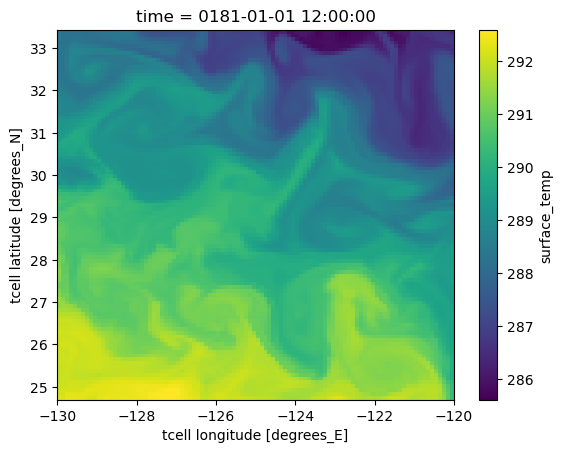

In [53]:
ds_test = ds_merged.isel(time=0, xt_ocean=slice(1500, 1600), yt_ocean=slice(1500, 1600))
ds_test.surface_temp.plot()

In [27]:
SST = ds_test.surface_temp
ds_finalTest = SST.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])
ds_finalTest

<xarray.DataArray 'surface_temp' (time: 31, yt_ocean: 100, xt_ocean: 100)> Size: 1MB
dask.array<getitem, shape=(31, 100, 100), dtype=float32, chunksize=(3, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) object 248B 0181-01-01 12:00:00 ... 0181-01-31 12:00:00
  * xt_ocean  (xt_ocean) float64 800B -130.0 -129.9 -129.8 ... -120.2 -120.1
  * yt_ocean  (yt_ocean) float64 800B 24.74 24.83 24.92 ... 33.22 33.3 33.38

In [43]:
Fda = xrft.dft(ds_finalTest.isel(time=0), dim="xt_ocean", true_phase=True, true_amplitude=True)
Fda.real

<xarray.DataArray (yt_ocean: 100, freq_xt_ocean: 100)> Size: 80kB
dask.array<real, shape=(100, 100), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>
Coordinates:
    time           object 8B 0181-01-01 12:00:00
  * yt_ocean       (yt_ocean) float64 800B 24.74 24.83 24.92 ... 33.3 33.38
  * freq_xt_ocean  (freq_xt_ocean) float64 800B -5.0 -4.9 -4.8 ... 4.7 4.8 4.9

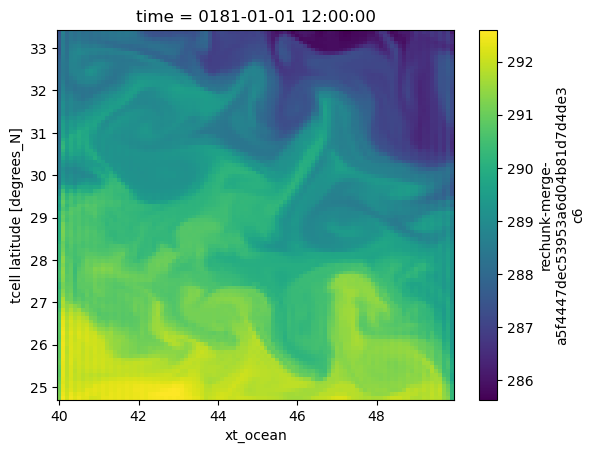

In [38]:
Fda_1 = xrft.idft(Fda, dim="freq_xt_ocean", true_phase=True, true_amplitude=True, lag=45)
Fda_1.real.plot()

# Power Spectra Example

In [56]:
ds_finalTest = ds_test.mean(dim="xt_ocean")
ds_finalTest.

<xarray.Dataset> Size: 5kB
Dimensions:       (yt_ocean: 100)
Coordinates:
    time          object 8B 0181-01-01 12:00:00
  * yt_ocean      (yt_ocean) float64 800B 24.74 24.83 24.92 ... 33.22 33.3 33.38
Data variables:
    slp           (yt_ocean) float32 400B dask.array<chunksize=(100,), meta=np.ndarray>
    v_ref         (yt_ocean) float32 400B dask.array<chunksize=(100,), meta=np.ndarray>
    u_ref         (yt_ocean) float32 400B dask.array<chunksize=(100,), meta=np.ndarray>
    t_ref         (yt_ocean) float32 400B dask.array<chunksize=(100,), meta=np.ndarray>
    q_ref         (yt_ocean) float32 400B dask.array<chunksize=(100,), meta=np.ndarray>
    wind          (yt_ocean) float32 400B dask.array<chunksize=(100,), meta=np.ndarray>
    surface_temp  (yt_ocean) float32 400B dask.array<chunksize=(100,), meta=np.ndarray>
    u_ocean       (yt_ocean) float32 400B dask.array<chunksize=(100,), meta=np.ndarray>
    v_ocean       (yt_ocean) float32 400B dask.array<chunksize=(100,), meta=np.ndarray>
    u_relative    (yt_ocean) float32 400B dask.array<chunksize=(100,), meta=np.ndarray>
    v_relative    (yt_ocean) float32 400B dask.array<chunksize=(100,), meta=np.ndarray>

In [65]:
U = ds_merged.u_relative.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])
freq_U = xrft.power_spectrum(U)
#V = ds_merged.v_relative
#ds_merged
freq_U

ValueError: Can't take Fourier transform because coodinate yt_ocean is not evenly spaced

In [50]:
with ProgressBar():
    uhat2 = xrft.power_spectrum(grid.interp(U,'X')[:,0].chunk({'time':1}),
                             dim=['xt_ocean','yt_ocean'], detrend='linear', window=True).compute()
    vhat2 = xrft.power_spectrum(grid.interp(V,'Y',boundary='fill')[:,0].chunk({'time':1}),
                             dim=['xt_ocean','yt_ocean'], detrend='linear', window=True).compute()
ekehat = .5*(uhat2 + vhat2)
ekehat

KeyError: 'X'